<a href="https://colab.research.google.com/github/wongdongwook/JSAC_MA-DeepSC/blob/main/CycleGAN(DA)_CelebA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import os
import math
import datetime
import pdb
import csv
import random
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch import autograd
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix
import torchvision.utils as vutils

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# if you use google TPU, this source code doesn't work. Cuz TPU is not GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using ' + str(device).upper())

Using CUDA


# Download celebA dataset

In [ ]:
!git clone https://github.com/yunjey/StarGAN.git

Cloning into 'StarGAN'...
remote: Enumerating objects: 162, done.
remote: Total 162 (delta 0), reused 0 (delta 0), pack-reused 162
Receiving objects: 100% (162/162), 13.76 MiB | 12.34 MiB/s, done.
Resolving deltas: 100% (79/79), done.


In [ ]:
!bash /content/StarGAN/download.sh celeba

Streaming output truncated to the last 5000 lines.
  inflating: ./data/celeba/images/012465.jpg  
  inflating: ./data/celeba/images/089057.jpg  
  inflating: ./data/celeba/images/147796.jpg  
  inflating: ./data/celeba/images/192463.jpg  
  inflating: ./data/celeba/images/142818.jpg  
  inflating: ./data/celeba/images/148061.jpg  
  inflating: ./data/celeba/images/184432.jpg  
  inflating: ./data/celeba/images/201157.jpg  
  inflating: ./data/celeba/images/097288.jpg  
  inflating: ./data/celeba/images/130371.jpg  
  inflating: ./data/celeba/images/082864.jpg  
  inflating: ./data/celeba/images/017429.jpg  
  inflating: ./data/celeba/images/186077.jpg  
  inflating: ./data/celeba/images/126843.jpg  
  inflating: ./data/celeba/images/200381.jpg  
  inflating: ./data/celeba/images/012555.jpg  
  inflating: ./data/celeba/images/092238.jpg  
  inflating: ./data/celeba/images/008151.jpg  
  inflating: ./data/celeba/images/171418.jpg  
  inflating: ./data/celeba/images/155589.jpg  
  inflati

# CycleGAN Network

In [ ]:
class ResidualBlock(nn.Module):
    """Residual Block with instance normalization."""
    def __init__(self, dim_in, dim_out):
        super(ResidualBlock, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(dim_in, dim_out, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(dim_out, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(dim_out, dim_out, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(dim_out, affine=True, track_running_stats=True))

    def forward(self, x):
        return x + self.main(x)


class Generator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, conv_dim=64):
        super(Generator, self).__init__()

        self.down_conv = nn.Sequential(
            nn.Conv2d(in_channels, conv_dim, kernel_size=7, stride=1, padding=3, bias=False),
            nn.InstanceNorm2d(conv_dim, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),

            nn.Conv2d(conv_dim, conv_dim * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(conv_dim * 2, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),

            nn.Conv2d(conv_dim * 2, conv_dim * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(conv_dim * 4, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
        )

        self.bottle_neck = nn.Sequential(
            ResidualBlock(conv_dim * 4, conv_dim * 4),
            ResidualBlock(conv_dim * 4, conv_dim * 4),
            ResidualBlock(conv_dim * 4, conv_dim * 4),
            ResidualBlock(conv_dim * 4, conv_dim * 4),
            ResidualBlock(conv_dim * 4, conv_dim * 4),
        )

        self.up_conv = nn.Sequential(
            nn.ConvTranspose2d(conv_dim * 4, conv_dim * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(conv_dim * 2, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(conv_dim * 2, conv_dim, kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(conv_dim, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(conv_dim, out_channels, kernel_size=7, stride=1, padding=3, bias=False),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.down_conv(x)
        x = self.bottle_neck(x)
        x = self.up_conv(x)

        return x


class Discriminator(nn.Module):
    def __init__(self,  in_channels=3, image_size=128, conv_dim=64):
        super(Discriminator, self).__init__()

        self.main_conv = nn.Sequential(
            nn.Conv2d(in_channels, conv_dim, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.01),

            nn.Conv2d(conv_dim, conv_dim * 2, kernel_size=4, stride=2, padding=1, bias=False), #1
            nn.LeakyReLU(0.01),

            nn.Conv2d(conv_dim * 2, conv_dim * 4, kernel_size=4, stride=2, padding=1, bias=False), #2
            nn.LeakyReLU(0.01),

            nn.Conv2d(conv_dim * 4, conv_dim * 8, kernel_size=4, stride=1, padding=1, bias=False), #3
            nn.LeakyReLU(0.01),

            nn.Conv2d(conv_dim * 8, conv_dim * 16, kernel_size=4, stride=1, padding=1, bias=False), #4
            nn.LeakyReLU(0.01),

            nn.Conv2d(conv_dim * 16, conv_dim * 32, kernel_size=4, stride=1, padding=1, bias=False), #5
            nn.LeakyReLU(0.01),

            nn.Conv2d(conv_dim * 32, conv_dim * 64, kernel_size=4, stride=1, padding=1, bias=False), #6
            nn.LeakyReLU(0.01),
        )

        kernel_size = int(image_size / np.power(2, 6))
        self.out = nn.Conv2d(conv_dim * 64, 1, kernel_size=kernel_size, stride=1, padding=0, bias=False)

    def forward(self, x):
        x = self.main_conv(x)
        x = self.out(x)

        return x

In [ ]:
# def conv_block(c_in, c_out, k_size=4, stride=2, pad=1, use_bn=True, transpose=False):
#     module = []
#     if transpose:
#         module.append(nn.ConvTranspose2d(c_in, c_out, k_size, stride, pad, output_padding=pad, bias=not use_bn))
#     else:
#         module.append(nn.Conv2d(c_in, c_out, k_size, stride, pad, bias=not use_bn))

#     if use_bn:
#         module.append(nn.BatchNorm2d(c_out))
#     return nn.Sequential(*module)


# class ResBlock(nn.Module):
#     def __init__(self, channels):
#         super(ResBlock, self).__init__()
#         self.conv1 = conv_block(channels, channels, k_size=3, stride=1, pad=1, use_bn=True)
#         self.conv2 = conv_block(channels, channels, k_size=3, stride=1, pad=1, use_bn=True)

#     def __call__(self, x):
#         x = F.relu(self.conv1(x))
#         return x + self.conv2(x)

# class Generator(nn.Module):
#     def __init__(self, in_channels=3, out_channels=3, conv_dim=64):
#         super(Generator, self).__init__()
#         self.conv1 = conv_block(in_channels, conv_dim, k_size=5, stride=1, pad=2, use_bn=True)
#         self.conv2 = conv_block(conv_dim, conv_dim * 2, k_size=3, stride=2, pad=1, use_bn=True)
#         self.conv3 = conv_block(conv_dim * 2, conv_dim * 4, k_size=3, stride=2, pad=1, use_bn=True)
#         self.res4 = ResBlock(conv_dim * 4)
#         self.tconv5 = conv_block(conv_dim * 4, conv_dim * 2, k_size=3, stride=2, pad=1, use_bn=True, transpose=True)
#         self.tconv6 = conv_block(conv_dim * 2, conv_dim, k_size=3, stride=2, pad=1, use_bn=True, transpose=True)
#         self.conv7 = conv_block(conv_dim, out_channels, k_size=5, stride=1, pad=2, use_bn=False)

#         # Initialization
#         for m in self.modules():
#             if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
#                 nn.init.normal_(m.weight, 0.0, 0.02)
#             elif isinstance(m, nn.BatchNorm2d):
#                 nn.init.normal_(m.weight.data, 1.0, 0.02)
#                 nn.init.constant_(m.bias, 0)

#     def forward(self, x):
#         x = F.relu(self.conv1(x))
#         x = F.relu(self.conv2(x))
#         x = F.relu(self.conv3(x))
#         x = F.relu(self.res4(x))
#         x = F.relu(self.tconv5(x))
#         x = F.relu(self.tconv6(x))
#         x = torch.tanh(self.conv7(x))
#         return x


# class Discriminator(nn.Module):
#     def __init__(self, channels=3, conv_dim=64):
#         super(Discriminator, self).__init__()
#         self.conv1 = conv_block(channels, conv_dim, use_bn=False)
#         self.conv2 = conv_block(conv_dim, conv_dim * 2)
#         self.conv3 = conv_block(conv_dim * 2, conv_dim * 4)
#         self.conv4 = conv_block(conv_dim * 4, 1, k_size=3, stride=1, pad=1, use_bn=False)

#         # Initialization
#         for m in self.modules():
#             if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
#                 nn.init.normal_(m.weight, 0.0, 0.02)
#             elif isinstance(m, nn.BatchNorm2d):
#                 nn.init.normal_(m.weight.data, 1.0, 0.02)
#                 nn.init.constant_(m.bias, 0)

#     def forward(self, x):
#         alpha = 0.2
#         x = F.leaky_relu(self.conv1(x), alpha)
#         x = F.leaky_relu(self.conv2(x), alpha)
#         x = F.leaky_relu(self.conv3(x), alpha)
#         x = self.conv4(x)
#         x = x.reshape([x.shape[0], -1]).mean(1)
#         return x

# Utils

In [ ]:
import matplotlib.image as mpimg

def generate_imgs(a, b, ab_gen, ba_gen, samples_path_ab, samples_path_ba, a_name, b_name, step_=0):
    ab_gen.eval()
    ba_gen.eval()

    b_fake = ab_gen(a)
    a_fake = ba_gen(b)

    a_imgs = torch.zeros((a.shape[0] * 2, 3, a.shape[2], a.shape[3]))
    b_imgs = torch.zeros((b.shape[0] * 2, 3, b.shape[2], b.shape[3]))

    even_idx = torch.arange(start=0, end=a.shape[0] * 2, step=2)
    odd_idx = torch.arange(start=1, end=a.shape[0] * 2, step=2)

    a_imgs[even_idx] = a.cpu()
    a_imgs[odd_idx] = b_fake.cpu()

    b_imgs[even_idx] = b.cpu()
    b_imgs[odd_idx] = a_fake.cpu()

    # rows = math.ceil((a.shape[0] * 2) ** 0.5)

    # Make sure the number of columns in the grid is even
    # total_images = a.shape[0] * 2
    # rows = math.ceil(math.sqrt(total_images))
    # if rows % 2 != 0:
    #     rows += 1  # Increment rows to make number of columns even

    rows = 4

    a_imgs_ = vutils.make_grid(a_imgs, normalize=True, nrow=rows)
    b_imgs_ = vutils.make_grid(b_imgs, normalize=True, nrow=rows)

    ab_filename = os.path.join(samples_path_ab, f'{a_name}_to_{b_name}_{step_}.png')
    ba_filename = os.path.join(samples_path_ba, f'{b_name}_to_{a_name}_{step_}.png')

    vutils.save_image(a_imgs_, ab_filename)
    vutils.save_image(b_imgs_, ba_filename)

    # Plot the images using matplotlib
    img_a = mpimg.imread(ab_filename)
    img_b = mpimg.imread(ba_filename)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img_a)
    plt.title(f'{a_name} to {b_name} Transformed')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img_b)
    plt.title(f'{b_name} to {a_name} Transformed')
    plt.axis('off')

    plt.show()

# DataLoader

In [ ]:
from torch.utils import data
from torchvision import transforms as T
from torchvision.datasets import ImageFolder
from PIL import Image

class CelebA(data.Dataset):
    """Dataset class for the CelebA dataset."""

    def __init__(self, image_dir, attr_path, selected_attrs, transform, mode):
        """Initialize and preprocess the CelebA dataset."""
        self.image_dir = image_dir
        self.attr_path = attr_path
        self.selected_attrs = selected_attrs
        self.transform = transform
        self.mode = mode
        self.train_dataset = []
        self.test_dataset = []
        self.attr2idx = {}
        self.idx2attr = {}
        self.preprocess()

        if mode == 'train':
            self.num_images = len(self.train_dataset)
        else:
            self.num_images = len(self.test_dataset)

    def preprocess(self):
        """Preprocess the CelebA attribute file."""
        lines = [line.rstrip() for line in open(self.attr_path, 'r')]
        all_attr_names = lines[1].split()
        for i, attr_name in enumerate(all_attr_names):
            self.attr2idx[attr_name] = i
            self.idx2attr[i] = attr_name

        lines = lines[2:]
        random.seed(1234)
        random.shuffle(lines)
        for i, line in enumerate(lines):
            split = line.split()
            filename = split[0]
            values = split[1:]

            label = []
            for attr_name in self.selected_attrs:
                idx = self.attr2idx[attr_name]
                label.append(values[idx] == '1')

            if (i+1) < 2000:
                self.test_dataset.append([filename, label])
            else:
                self.train_dataset.append([filename, label])

        print('Finished preprocessing the CelebA dataset...')

    def __getitem__(self, index):
        """Return one image and its corresponding attribute label."""
        dataset = self.train_dataset if self.mode == 'train' else self.test_dataset
        filename, label = dataset[index]
        image = Image.open(os.path.join(self.image_dir, filename))
        return self.transform(image), torch.FloatTensor(label)

    def __len__(self):
        """Return the number of images."""
        return self.num_images


# class CelebA(data.Dataset):
#     def __init__(self, image_dir, attr_path, selected_attrs, transform, mode):
#         self.image_dir = image_dir
#         self.attr_path = attr_path
#         self.selected_attrs = selected_attrs
#         self.transform = transform
#         self.mode = mode
#         self.dataset = []
#         self.attr2idx = {}
#         self.idx2attr = {}
#         self.preprocess()

#         if mode == 'train':
#             self.num_images = len(self.dataset)
#         else:
#             self.num_images = len(self.dataset)

#     def preprocess(self):
#         lines = [line.rstrip() for line in open(self.attr_path, 'r')]
#         all_attr_names = lines[1].split()
#         for i, attr_name in enumerate(all_attr_names):
#             self.attr2idx[attr_name] = i
#             self.idx2attr[i] = attr_name

#         lines = lines[2:]
#         for line in lines:
#             split = line.split()
#             filename = split[0]
#             values = split[1:]

#             label = []
#             for attr_name in self.selected_attrs:
#                 idx = self.attr2idx[attr_name]
#                 # Adjust labels to map Male: -1 to 0, and Male: 1 to 1
#                 label_value = int(values[idx])
#                 if label_value == -1:
#                     label.append(0)
#                 else:
#                     label.append(1)

#             self.dataset.append([filename, label])

#     def __getitem__(self, index):
#         filename, label = self.dataset[index]
#         image = Image.open(os.path.join(self.image_dir, filename))
#         return self.transform(image), torch.FloatTensor(label)

#     def __len__(self):
#         return self.num_images



def get_loader(image_dir, attr_path, selected_attrs, crop_size=178, image_size=128,
               batch_size=16, dataset='CelebA', mode='train', num_workers=1):
    """Build and return a data loader."""
    transform = []
    if mode == 'train':
        transform.append(T.RandomHorizontalFlip())
    transform.append(T.CenterCrop(crop_size))
    transform.append(T.Resize(image_size))
    transform.append(T.ToTensor())
    transform.append(T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)))
    transform = T.Compose(transform)

    if dataset == 'CelebA':
        dataset = CelebA(image_dir, attr_path, selected_attrs, transform, mode)
    elif dataset == 'RaFD':
        dataset = ImageFolder(image_dir, transform)

    data_loader = data.DataLoader(dataset=dataset,
                                  batch_size=batch_size,
                                  shuffle=(mode=='train'),
                                  num_workers=num_workers)
    return dataset, data_loader

# Test dataset

In [ ]:
def plot_tensor_as_image(tensor):
    if tensor.ndim == 3 and tensor.shape[0] == 3:  # Check if it's a 3-channel image
        tensor = tensor.permute(1, 2, 0)  # Reorder dimensions to (H, W, C)

    # Normalize from [-1, 1] to [0, 1]
    tensor = (tensor + 1) / 2
    tensor = torch.clamp(tensor, 0, 1)  # Ensure the tensor is within [0, 1] after normalization

    plt.imshow(tensor)
    plt.show()

def get_label_from_tensor(label_tensor, label_texts):
    # Ensure the tensor is a 1D tensor and has the same length as label_texts
    assert label_tensor.ndim == 1
    assert len(label_tensor) == len(label_texts)

    # Find indices with value 1 and map to corresponding text labels
    labels = [label_texts[i] for i in range(len(label_tensor)) if label_tensor[i] == 1]
    return ', '.join(labels)  # Join labels with a comma if you expect multiple '1's

In [ ]:
celeba_image_dir = '/content/data/celeba/images'
attr_path = '/content/data/celeba/list_attr_celeba.txt'

"""
All possible attrs:
5_o_Clock_Shadow Arched_Eyebrows Attractive Bags_Under_Eyes Bald Bangs Big_Lips
Big_Nose Black_Hair Blond_Hair Blurry Brown_Hair Bushy_Eyebrows Chubby Double_Chin
Eyeglasses Goatee Gray_Hair Heavy_Makeup High_Cheekbones Male Mouth_Slightly_Open
Mustache Narrow_Eyes No_Beard Oval_Face Pale_Skin Pointy_Nose Receding_Hairline
Rosy_Cheeks Sideburns Smiling Straight_Hair Wavy_Hair Wearing_Earrings Wearing_Hat
Wearing_Lipstick Wearing_Necklace Wearing_Necktie Young
"""
selected_attrs = ['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Male', 'Young']
# selected_attrs = {
#     'Black_Hair': 1,
#     'Blond_Hair': 1,
#     'Brown_Hair': 1,
#     'Male': 1,
#     'Young': 1
# }
celeba_crop_size = 178
image_size = 128
batch_size = 16

ds, celeba_loader = get_loader(celeba_image_dir, attr_path, selected_attrs,
                           celeba_crop_size, image_size, batch_size,
                           dataset='CelebA', mode='train')
print(len(ds))

Finished preprocessing the CelebA dataset...
200600


59495 Black_Hair, Young


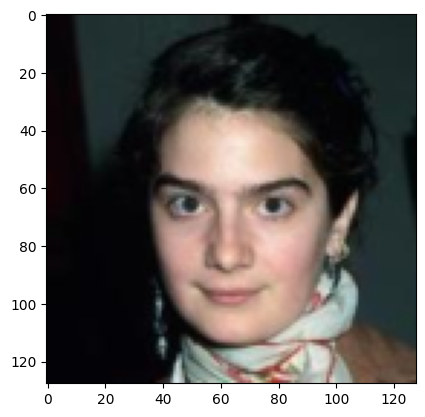

In [ ]:
id = random.randint(0, len(ds))
print(id, get_label_from_tensor(ds[id][1], selected_attrs))
plot_tensor_as_image(ds[id][0])

# Data Filter by Attributes

In [ ]:
def filter_by_attributes(df, attributes, keep_all_columns=True):
    # Initialize the filtered DataFrame as the full DataFrame
    filtered_df = df.copy()

    # Filter the DataFrame iteratively for each attribute condition
    for attr, val in attributes.items():
        filtered_df = filtered_df[filtered_df[attr] == val]

    # Optionally, select only the columns related to the specified attributes
    if not keep_all_columns:
        relevant_columns = list(attributes.keys())
        filtered_df = filtered_df[relevant_columns]

    return filtered_df

def save_to_file(df, output_path):

    # Get the header from the DataFrame, which are the attribute names
    header = ' '.join(df.columns.tolist())

    # Get the number of entries in the DataFrame
    num_entries = len(df)

    # Open a file to write
    with open(output_path, 'w') as file:
        # Write the number of entries and the header
        file.write(f"{num_entries}\n")
        file.write(header + "\n")

        # Write the data from the DataFrame
        for index, row in df.iterrows():
            row_str = ' '.join(map(str, row.tolist()))
            file.write(f"{index} {row_str}\n")

    print(f"Filtered data saved to {output_path}")

In [ ]:
# Load attributes file
df = pd.read_csv(attr_path, delim_whitespace=True, header=1)

In [ ]:
# Define the desired attributes (1 for positive, -1 for negative)
attr_dict_a = {'Male': 1}
attr_dict_b = {'Male': -1}
# attr_a = list(attr_dict_a.keys())
# attr_b = list(attr_dict_b.keys())
attr_a = 'Male'
attr_b = 'Female'

df_a = filter_by_attributes(df, attr_dict_a, keep_all_columns=False)
df_b = filter_by_attributes(df, attr_dict_b, keep_all_columns=False)

print(len(df_a), len(df_b))

84434 118165


In [ ]:
save_path_a = f'/content/data/celeba/{attr_a}.txt'
save_path_b = f'/content/data/celeba/{attr_b}.txt'

save_to_file(df_a, save_path_a)
save_to_file(df_b, save_path_b)

Filtered data saved to /content/data/celeba/Male.txt
Filtered data saved to /content/data/celeba/Female.txt


In [ ]:
ds_a, ds_loader_a = get_loader(celeba_image_dir, save_path_a, attr_dict_a,
                           celeba_crop_size, image_size, batch_size,
                           dataset='CelebA', mode='train')

ds_b, ds_loader_b = get_loader(celeba_image_dir, save_path_b, attr_dict_b,
                           celeba_crop_size, image_size, batch_size,
                           dataset='CelebA', mode='train')

print(len(ds_a), len(ds_b))
print(len(ds_loader_a), len(ds_loader_b))

84434 118165
5278 7386


In [ ]:
iters_per_epoch = min(len(ds_loader_a), len(ds_loader_b))
iters_per_epoch

5278

In [ ]:
df_b.head()

,Male
000001.jpg,-1
000002.jpg,-1
000004.jpg,-1
000005.jpg,-1
000006.jpg,-1


In [ ]:
id = random.randint(0, min(len(ds_a), len(ds_b)))
print(ds_a[id][1])
print(ds_b[id][1])
print(id, get_label_from_tensor(ds_a[id][1], list(attr_dict_a.keys())))
plot_tensor_as_image(ds_a[id][0])

id = random.randint(0, len(ds_b))
print(id, get_label_from_tensor(ds_b[id][1], list(attr_dict_b.keys())))
plot_tensor_as_image(ds_b[id][0])

# Train Settings

In [ ]:
EPOCHS = 20
IMGS_TO_DISPLAY = 10
BATCH_SIZE = 16
CONV_DIM = 16

In [ ]:
model_path = '/content/drive/My Drive/CycleGAN_celebA/model'
os.makedirs(model_path, exist_ok=True)
samples_path = '/content/drive/My Drive/CycleGAN_celebA/samples'
os.makedirs(samples_path, exist_ok=True)

In [ ]:
gen_ab = Generator(in_channels=3, out_channels=3, conv_dim=CONV_DIM).to(device).train()
gen_ba = Generator(in_channels=3, out_channels=3, conv_dim=CONV_DIM).to(device).train()

dis_a = Discriminator(in_channels=3, conv_dim=CONV_DIM).to(device).train()
dis_b = Discriminator(in_channels=3, conv_dim=CONV_DIM).to(device).train()

# Define Optimizers
g_optim = optim.Adam(list(gen_ab.parameters()) + list(gen_ba.parameters()),
                      lr=0.0001,
                      betas=(0.5, 0.999))

d_optim = optim.Adam(list(dis_a.parameters()) + list(dis_b.parameters()),
                      lr=0.0001,
                      betas=(0.5, 0.999))

# Fix images for viz
loader_iter_a = iter(ds_loader_a)
loader_iter_b = iter(ds_loader_b)
fixed_a = next(loader_iter_a)
fixed_b = next(loader_iter_b)
fixed_a, _ = fixed_a
fixed_b, _ = fixed_b
fixed_a = fixed_a[:IMGS_TO_DISPLAY].to(device)
fixed_b = fixed_b[:IMGS_TO_DISPLAY].to(device)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [ ]:
current_setting = f'{attr_a}_{attr_b}_conv{CONV_DIM}_batch{BATCH_SIZE}'
print(f'Current train setting: {current_setting}')

samples_path_ab = os.path.join(samples_path, f'{attr_a}_to_{attr_b}')
os.makedirs(samples_path_ab, exist_ok=True)
samples_path_ba = os.path.join(samples_path, f'{attr_b}_to_{attr_a}')
os.makedirs(samples_path_ba, exist_ok=True)

Current train setting: Male_Female_conv16_batch16


# Training

## Training (Male <=> Female)

In [ ]:
train_info = []
total_iter = 0
csv_mode = 'w'

for epoch in range(EPOCHS):

    g_adv_losses = []
    g_cyc_losses = []
    g_losses = []
    d_losses = []

    print()
    for i, (data_a, data_b) in tqdm(enumerate(zip(ds_loader_a, ds_loader_b)), total=iters_per_epoch, desc=f'Epoch {epoch+1} train progress'):
        total_iter += 1
        gen_ab.train()
        gen_ba.train()
        dis_a.train()
        dis_b.train()

        # Real Images
        real_a, _ = data_a
        real_b, _ = data_b
        real_a = real_a.to(device)
        real_b = real_b.to(device)

        # Fake Images
        fake_b = gen_ab(real_a)
        fake_a = gen_ba(real_b)

        # Train Discriminators
        real_a_out = dis_a(real_a)
        fake_a_out = dis_a(fake_a.detach())
        d_loss_a = (torch.mean((real_a_out - 1) ** 2) + torch.mean(fake_a_out ** 2)) / 2

        real_b_out = dis_b(real_b)
        fake_b_out = dis_b(fake_b.detach())
        d_loss_b = (torch.mean((real_b_out - 1) ** 2) + torch.mean(fake_b_out ** 2)) / 2

        d_optim.zero_grad()
        d_loss = d_loss_a + d_loss_b
        d_loss.backward()
        d_optim.step()

        # Train Generators
        fake_a_out = dis_a(fake_a)
        fake_b_out = dis_b(fake_b)

        g_adv_loss_a = torch.mean((fake_a_out - 1) ** 2)
        g_adv_loss_b = torch.mean((fake_b_out - 1) ** 2)
        g_adv_loss = g_adv_loss_a + g_adv_loss_b

        g_cyc_loss_a = (real_a - gen_ba(fake_b)).abs().mean()
        g_cyc_loss_b = (real_b - gen_ab(fake_a)).abs().mean()
        g_cyc_loss = g_cyc_loss_a + g_cyc_loss_b

        g_optim.zero_grad()
        g_loss = g_adv_loss + 10 * g_cyc_loss
        g_loss.backward()
        g_optim.step()

        g_adv_losses.append(g_adv_loss.item())
        g_cyc_losses.append(g_cyc_loss.item())
        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())

        if total_iter % 100 == 0:
            print()
            print(f'Total iter: {total_iter}')
            print(f'g_adv_loss = {g_adv_loss.item():.6f}, g_cyc_loss = {g_cyc_loss.item():.6f}, g_loss = {g_loss.item():.6f}')
            print(f'd_loss_a = {d_loss_a.item():.6f}, d_loss_b = {d_loss_b.item():.6f}, d_loss = {d_loss.item():.6f}')
            print("------------------------------------------------------------")
            print()

        if total_iter % 500 == 0:
            generate_imgs(fixed_a, fixed_b, gen_ab, gen_ba, samples_path_ab, samples_path_ba, attr_a, attr_b, total_iter)
            print()

    avg_g_adv_loss = np.mean(g_adv_losses)
    avg_g_cyc_loss = np.mean(g_cyc_losses)
    avg_g_loss = np.mean(g_losses)
    avg_d_loss = np.mean(d_losses)

    train_info.append((avg_g_adv_loss, avg_g_cyc_loss, avg_g_loss, avg_d_loss))

    with open(os.path.join(model_path, f'train_info_backup_{current_setting}.csv'), csv_mode) as f:
        writer = csv.writer(f)
        writer.writerow((avg_g_adv_loss, avg_g_cyc_loss, avg_g_loss, avg_d_loss))

    csv_mode = 'a'

    print(f'\nGenerator:\nadv_loss: {avg_g_adv_loss:.6f}, cyc_loss: {avg_g_cyc_loss:.6f}')
    print(f'Total loss: {avg_g_loss:.6f}')
    print("------------------------------------------------------------")
    print('Discriminator:')
    print(f'Total loss: {avg_d_loss:.6f}')
    print("============================================================")

    torch.save(gen_ab.state_dict(), os.path.join(model_path, f'gen_{attr_a}_{attr_b}_conv{CONV_DIM}_batch{BATCH_SIZE}.pkl'))
    torch.save(gen_ba.state_dict(), os.path.join(model_path, f'gen_{attr_b}_{attr_a}_conv{CONV_DIM}_batch{BATCH_SIZE}.pkl'))

    torch.save(dis_a.state_dict(), os.path.join(model_path, f'dis_{attr_a}_conv{CONV_DIM}_batch{BATCH_SIZE}.pkl'))
    torch.save(dis_b.state_dict(), os.path.join(model_path, f'dis_{attr_b}_conv{CONV_DIM}_batch{BATCH_SIZE}.pkl'))

train_info_df = pd.DataFrame(train_info, columns=['g_adv_loss', 'g_cyc_loss', 'g_loss', 'd_loss'])
train_info_df.to_csv(os.path.join(model_path, f'train_info_{current_setting}.csv'))

print('All done')

## Training (Young <=> Old)

In [ ]:
# Define the desired attributes (1 for positive, -1 for negative)
attr_dict_a = {'Young': 1}
attr_dict_b = {'Young': -1}
# attr_a = list(attr_dict_a.keys())
# attr_b = list(attr_dict_b.keys())
attr_a = 'Young'
attr_b = 'Old'

df_a = filter_by_attributes(df, attr_dict_a, keep_all_columns=False)
df_b = filter_by_attributes(df, attr_dict_b, keep_all_columns=False)

print(len(df_a), len(df_b))

156734 45865


In [ ]:
save_path_a = f'/content/data/celeba/{attr_a}.txt'
save_path_b = f'/content/data/celeba/{attr_b}.txt'

save_to_file(df_a, save_path_a)
save_to_file(df_b, save_path_b)

Filtered data saved to /content/data/celeba/Young.txt
Filtered data saved to /content/data/celeba/Old.txt


In [ ]:
ds_a, ds_loader_a = get_loader(celeba_image_dir, save_path_a, attr_dict_a,
                           celeba_crop_size, image_size, batch_size,
                           dataset='CelebA', mode='train')

ds_b, ds_loader_b = get_loader(celeba_image_dir, save_path_b, attr_dict_b,
                           celeba_crop_size, image_size, batch_size,
                           dataset='CelebA', mode='train')

print(len(ds_a), len(ds_b))
print(len(ds_loader_a), len(ds_loader_b))

156734 45865
9796 2867


In [ ]:
iters_per_epoch = min(len(ds_loader_a), len(ds_loader_b))
iters_per_epoch

2867

In [ ]:
df_b.head()

,Young
000015.jpg,-1
000018.jpg,-1
000021.jpg,-1
000030.jpg,-1
000032.jpg,-1


In [ ]:
id = random.randint(0, min(len(ds_a), len(ds_b)))
print(ds_a[id][1])
print(ds_b[id][1])
print(id, get_label_from_tensor(ds_a[id][1], list(attr_dict_a.keys())))
plot_tensor_as_image(ds_a[id][0])

id = random.randint(0, len(ds_b))
print(id, get_label_from_tensor(ds_b[id][1], list(attr_dict_b.keys())))
plot_tensor_as_image(ds_b[id][0])

In [ ]:
gen_ab = Generator(in_channels=3, out_channels=3, conv_dim=CONV_DIM).to(device).train()
gen_ba = Generator(in_channels=3, out_channels=3, conv_dim=CONV_DIM).to(device).train()

dis_a = Discriminator(in_channels=3, conv_dim=CONV_DIM).to(device).train()
dis_b = Discriminator(in_channels=3, conv_dim=CONV_DIM).to(device).train()

# Define Optimizers
g_optim = optim.Adam(list(gen_ab.parameters()) + list(gen_ba.parameters()),
                      lr=0.0001,
                      betas=(0.5, 0.999))

d_optim = optim.Adam(list(dis_a.parameters()) + list(dis_b.parameters()),
                      lr=0.0001,
                      betas=(0.5, 0.999))

# Fix images for viz
loader_iter_a = iter(ds_loader_a)
loader_iter_b = iter(ds_loader_b)
fixed_a = next(loader_iter_a)
fixed_b = next(loader_iter_b)
fixed_a, _ = fixed_a
fixed_b, _ = fixed_b
fixed_a = fixed_a[:IMGS_TO_DISPLAY].to(device)
fixed_b = fixed_b[:IMGS_TO_DISPLAY].to(device)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [ ]:
current_setting = f'{attr_a}_{attr_b}_conv{CONV_DIM}_batch{BATCH_SIZE}'
print(f'Current train setting: {current_setting}')

samples_path_ab = os.path.join(samples_path, current_setting, f'{attr_a}_to_{attr_b}')
os.makedirs(samples_path_ab, exist_ok=True)
samples_path_ba = os.path.join(samples_path, current_setting, f'{attr_b}_to_{attr_a}')
os.makedirs(samples_path_ba, exist_ok=True)
os.makedirs(os.path.join(model_path, current_setting), exist_ok=True)

Current train setting: Young_Old_conv16_batch16


In [ ]:
train_info = []
total_iter = 0
csv_mode = 'w'

for epoch in range(EPOCHS):

    g_adv_losses = []
    g_cyc_losses = []
    g_losses = []
    d_losses = []

    print()
    for i, (data_a, data_b) in tqdm(enumerate(zip(ds_loader_a, ds_loader_b)), total=iters_per_epoch, desc=f'Epoch {epoch+1} train progress'):
        total_iter += 1
        gen_ab.train()
        gen_ba.train()
        dis_a.train()
        dis_b.train()

        # Real Images
        real_a, _ = data_a
        real_b, _ = data_b
        real_a = real_a.to(device)
        real_b = real_b.to(device)

        # Fake Images
        fake_b = gen_ab(real_a)
        fake_a = gen_ba(real_b)

        # Train Discriminators
        real_a_out = dis_a(real_a)
        fake_a_out = dis_a(fake_a.detach())
        d_loss_a = (torch.mean((real_a_out - 1) ** 2) + torch.mean(fake_a_out ** 2)) / 2

        real_b_out = dis_b(real_b)
        fake_b_out = dis_b(fake_b.detach())
        d_loss_b = (torch.mean((real_b_out - 1) ** 2) + torch.mean(fake_b_out ** 2)) / 2

        d_optim.zero_grad()
        d_loss = d_loss_a + d_loss_b
        d_loss.backward()
        d_optim.step()

        # Train Generators
        fake_a_out = dis_a(fake_a)
        fake_b_out = dis_b(fake_b)

        g_adv_loss_a = torch.mean((fake_a_out - 1) ** 2)
        g_adv_loss_b = torch.mean((fake_b_out - 1) ** 2)
        g_adv_loss = g_adv_loss_a + g_adv_loss_b

        g_cyc_loss_a = (real_a - gen_ba(fake_b)).abs().mean()
        g_cyc_loss_b = (real_b - gen_ab(fake_a)).abs().mean()
        g_cyc_loss = g_cyc_loss_a + g_cyc_loss_b

        g_optim.zero_grad()
        g_loss = g_adv_loss + 10 * g_cyc_loss
        g_loss.backward()
        g_optim.step()

        g_adv_losses.append(g_adv_loss.item())
        g_cyc_losses.append(g_cyc_loss.item())
        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())

        if total_iter % 100 == 0:
            print()
            print(f'Total iter: {total_iter}')
            print(f'g_adv_loss = {g_adv_loss.item():.6f}, g_cyc_loss = {g_cyc_loss.item():.6f}, g_loss = {g_loss.item():.6f}')
            print(f'd_loss_a = {d_loss_a.item():.6f}, d_loss_b = {d_loss_b.item():.6f}, d_loss = {d_loss.item():.6f}')
            print("------------------------------------------------------------")
            print()

        if total_iter % 500 == 0:
            generate_imgs(fixed_a, fixed_b, gen_ab, gen_ba, samples_path_ab, samples_path_ba, attr_a, attr_b, total_iter)
            print()

    avg_g_adv_loss = np.mean(g_adv_losses)
    avg_g_cyc_loss = np.mean(g_cyc_losses)
    avg_g_loss = np.mean(g_losses)
    avg_d_loss = np.mean(d_losses)

    train_info.append((avg_g_adv_loss, avg_g_cyc_loss, avg_g_loss, avg_d_loss))

    with open(os.path.join(model_path, current_setting, f'train_info_backup_{current_setting}.csv'), csv_mode) as f:
        writer = csv.writer(f)
        writer.writerow((avg_g_adv_loss, avg_g_cyc_loss, avg_g_loss, avg_d_loss))

    csv_mode = 'a'

    print(f'\nGenerator:\nadv_loss: {avg_g_adv_loss:.6f}, cyc_loss: {avg_g_cyc_loss:.6f}')
    print(f'Total loss: {avg_g_loss:.6f}')
    print("------------------------------------------------------------")
    print('Discriminator:')
    print(f'Total loss: {avg_d_loss:.6f}')
    print("============================================================")

    torch.save(gen_ab.state_dict(), os.path.join(model_path, current_setting, f'gen_{attr_a}_{attr_b}_conv{CONV_DIM}_batch{BATCH_SIZE}.pkl'))
    torch.save(gen_ba.state_dict(), os.path.join(model_path, current_setting, f'gen_{attr_b}_{attr_a}_conv{CONV_DIM}_batch{BATCH_SIZE}.pkl'))

    torch.save(dis_a.state_dict(), os.path.join(model_path, current_setting, f'dis_{attr_a}_conv{CONV_DIM}_batch{BATCH_SIZE}.pkl'))
    torch.save(dis_b.state_dict(), os.path.join(model_path, current_setting, f'dis_{attr_b}_conv{CONV_DIM}_batch{BATCH_SIZE}.pkl'))

df = pd.DataFrame(train_info, columns=['g_adv_loss', 'g_cyc_loss', 'g_loss', 'd_loss'])
df.to_csv(os.path.join(model_path, current_setting, f'train_info_{current_setting}.csv'))

print('All done')

In [ ]:
from google.colab import runtime
runtime.unassign()

# Evaluation

In [ ]:
ds, test_loader = get_loader(celeba_image_dir, attr_path, selected_attrs,
                             celeba_crop_size, image_size, batch_size=8,
                             dataset='CelebA', mode='test')
print(len(ds))

model_path = '/content/drive/My Drive/CycleGAN_celebA/model'
os.makedirs(model_path, exist_ok=True)
samples_path = '/content/drive/My Drive/CycleGAN_celebA/samples'
os.makedirs(samples_path, exist_ok=True)

attr_a = 'Young'
attr_b = 'Old'

# Load the pre-trained generator
gen = Generator(in_channels=3, out_channels=3, conv_dim=16).to(device)
gen.load_state_dict(torch.load(os.path.join(model_path, f'Young_Old_conv16_batch16', f'gen_{attr_a}_{attr_b}.pkl')))
gen.eval()

samples_test_path = os.path.join(samples_path, 'test', f'{attr_b}')
os.makedirs(samples_test_path, exist_ok=True)

# Generate fake images from real images
for i, (real, _) in tqdm(enumerate(test_loader), total=len(test_loader)):

    real = real.to(device)

    fake = gen(real)

    # Save Img
    imgs = torch.zeros((real.shape[0] * 2, 3, real.shape[2], real.shape[3]))

    even_idx = torch.arange(start=0, end=real.shape[0] * 2, step=2)
    odd_idx = torch.arange(start=1, end=real.shape[0] * 2, step=2)

    imgs[even_idx] = real.cpu()
    imgs[odd_idx] = fake.cpu()

    imgs_ = vutils.make_grid(imgs, normalize=True, nrow=4)

    filename = os.path.join(samples_test_path, f'{i}.png')
    vutils.save_image(imgs_, filename)

    if i % 50 == 0:
        # Plot
        np_image = imgs_.cpu().detach().numpy()
        np_image = np.transpose(np_image, (1, 2, 0))
        # Plot using matplotlib
        plt.figure(figsize=(8, 8)) # You can adjust the figure size as needed
        plt.imshow(np_image)
        plt.axis('off')  # Optional: Remove axes for a cleaner look
        plt.show()


In [ ]:
real.shape

torch.Size([16, 3, 128, 128])